In [1]:
import numpy as np
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import pylab as plt #import Matplotlib plotting interface
import math
import community as community_louvain
import collections

In [2]:
class address:
    
    def __init__(self, coins, public):
        
        self.public = public
        self.coins = coins
       
    def receive(self, amount):
        self.coins += amount
        
    def send(self, other, amount):
        
        if(self.coins >= amount):
            other.receive(amount)
            self.coins -= amount
            amount_sent = amount
        else:
            
            other.receive(self.coins)
            self.coins = 0
            amount_sent = self.coins 
            
        return amount_sent

class transaction:
        
    def __init__(self, sums_in, sums_out):

        self.sums_in = sums_in
        self.sums_out = sums_out
        
        
class blockchain:
    
    def __init__(self, number_of_users, coins, num_shops, mixing_probability, number_of_mixers):
        
        self.num_shops = num_shops
        self.network = np.zeros((number_of_users + number_of_mixers, number_of_users + number_of_mixers))
        self.addresses = []
        self.transactions = []
        for i in range(number_of_users):
            self.addresses.append(user(mixing_probability, number_of_users, coins, i))
        self.num_users = len(self.addresses)
        i = number_of_users
        while(i < number_of_users + number_of_mixers):
            
            self.addresses.append(address(0, i))
            i = i + 1
            
    def generate_address(self):
        self.addresses.append(address(coins, len(self.addresses)))
        
    def size(self):
        return len(self.addresses)
            
    def update_network(self, address_send, address_receive, amount):
        self.network[address_send][address_receive] += amount
    
    def print_ledger(self):
        
        for address in self.addresses:
            print("amount: " + str(address.coins) + " id:" + str(address.public))
    """     
    def execute_transactions(self, transactions_list):
        sums_in = np.zeros(len(self.addresses))
        sums_out = np.zeros(len(self.addresses))
        for addresses_to_send in transactions_list:
            
            for i, address in enumerate(self.addresses):
                if(addresses_to_send[i] != i and i > self.num_shops -1):
                    amount_sent = address.send(self.addresses[addresses_to_send[i]], 1)
                    sums_in[i] += amount_sent
                    sums_out[addresses_to_send[i]] += amount_sent
                    self.update_network(i, addresses_to_send[i], amount_sent)
            
        self.transactions.append(transaction(sums_in, sums_out))
    """     
    
    def execute_transactions(self, addresses_in, addresses_out, sums):
        sums_in = np.zeros(len(self.addresses))
        sums_out = np.zeros(len(self.addresses))
        
        for i in range(len(addresses_in)):
            address_in = self.addresses[addresses_in[i]]
            address_out = self.addresses[addresses_out[i]]
            sum_to_send = sums[i]
            amount_sent = address_in.send(address_out, sum_to_send)
            sums_in[addresses_in[i]] += amount_sent
            sums_out[addresses_out[i]] += amount_sent
            self.update_network(addresses_in[i], addresses_out[i], amount_sent)
            
        self.transactions.append(transaction(sums_in, sums_out))
        
        
class simulation:
    
    def __init__(self, size, coins, num_shops, mixing_probability, number_of_steps):
        self.blockchain  = blockchain(size, coins, num_shops, mixing_probability, number_of_steps)
        self.mixer = mixer(size, number_of_steps)
        self.number_of_steps = number_of_steps
        self.num_shops = num_shops
        
    
    def generate_sending_probabilities(self):
        
        probabilities = []
        for i in range(self.blockchain.size()):
            if(i < self.num_shops):
                probabilities.append(1/self.blockchain.size() * 3)
            else:
                probabilities.append((1 - (1/self.blockchain.size() * 3) * self.num_shops)/ (self.blockchain.size() - self.num_shops))
        return probabilities
    
    def generate_transactions_network(self):
        size = self.blockchain.size() + len(self.blockchain.transactions)
        self.transactions_network = np.zeros((size, size))
        
        for i, transaction in enumerate(self.blockchain.transactions):
            for j in range(len(transaction.sums_in)):
                self.transactions_network[j][self.blockchain.size() + i] += transaction.sums_in[j]
                self.transactions_network[self.blockchain.size() + i][j] += transaction.sums_out[j]
                

        return self.transactions_network
    
    def step(self):   
        number_of_transactions = random.randint(1, 2)
        transactions = []
        for i in range(number_of_transactions):
            probabilities = self.generate_sending_probabilities()
            addresses_to_send = np.random.choice(self.blockchain.size(), self.blockchain.size(), probabilities) 
            transactions.append(addresses_to_send)
        self.blockchain.execute_transactions(transactions)
        
    def step_with_mixer(self):
        transaction_to_perform = [self.blockchain.size()]
        for i in range(self.blockchain.num_users):
            mix, address, amount = self.blockchain.addresses[i].generate_transfer(self.blockchain.size())
            if(mix == 0):
                self.blockchain.execute_transactions([i], [address], [amount])
            else:
                self.blockchain.addresses[self.blockchain.size() - 1].add_to_mixng_pool(i, address, amount)
                self.blockchain.execute_transactions([i], [self.blockchain.size() - 1], [amount])
        addresses_out, sums_out = self.blockchain.addresses[self.blockchain.size() - 1].send_out()
        addresses_in = []
        for i in range(len(addresses_out)):
            addresses_in.append(self.blockchain.size() - 1)
        self.blockchain.execute_transactions(addresses_in, addresses_out, sums_out)
        
    def step_with_multiple_addresses(self):
        
        #transaction_to_perform = [self.blockchain.size()]
        
        for i in range(self.blockchain.num_users):
            mix, address, amount = self.blockchain.addresses[i].generate_transfer(self.blockchain.size())
            if(mix == 0):
                self.blockchain.execute_transactions([i], [address], [amount])
            else:
                mixer_address = self.mixer.get_address()
                self.mixer.add_to_mixng_pool(i, address, amount)
                self.blockchain.execute_transactions([i], [mixer_address], [amount])
        mixer_address, addresses_out, sums_out = self.mixer.send_out()
        addresses_in = []
        for i in range(len(addresses_out)):
            addresses_in.append(mixer_address)
        self.blockchain.execute_transactions(addresses_in, addresses_out, sums_out)
            
    
    def simulate_random_exchange(self):
        
        for i in range(self.number_of_steps):
            self.step_with_multiple_addresses()
    
    def print_ledger(self):
        self.blockchain.print_ledger()
        
            

In [3]:
# User and Mixer with Multiple addresses

class mixer():
    
    def __init__(self, num_of_users, num_of_addresses):
        
        self.addresses_in = []
        self.addresses_out = []
        self.sums = []
        self.addresses = list(range(num_of_users, num_of_users+num_of_addresses))
        self.used_addresses = 0
    
    def add_address(self, public):
        self.addresses.append(public)
    
    def get_address(self):
        return self.addresses[self.used_addresses]
    
    def add_to_mixng_pool(self, address_in, address_out, sum_to_send):
        self.addresses_in.append(address_in)
        self.addresses_out.append(address_out)
        self.sums.append(sum_to_send)
    
    def send_out(self):
        
        incoming = self.addresses_in
        outcoming = self.addresses_in
        sums_out = self.sums

        if(len(self.sums) > 0):
            
            self.used_addresses += 1
            self.addresses_in = []
            self.addresses_out = []
            self.sums = []
            return self.addresses[self.used_addresses - 1], outcoming, sums_out
        
        self.addresses_in = []
        self.addresses_out = []
        self.sums = []
        
        return self.addresses[self.used_addresses], outcoming, sums_out
        
    

class user(address):
    
    def __init__(self, mixing_probability, mixer_address, *args, **kwargs):
        self.mixing_probability = mixing_probability 
        self.mixer_address = mixer_address
        super(user, self).__init__(*args, **kwargs)
        
    def generate_transfer(self, blockchain_size):
        probabilities = [1 - self.mixing_probability, self.mixing_probability]
        action = random.choices([0,1], weights = probabilities, k = 1) 
        amount_to_send = self.coins * random.uniform(0, 1)
        
        address_to_send = -1
        while(address_to_send == -1 or address_to_send == self.mixer_address):
            address_to_send = np.random.choice(blockchain_size, 1)
        
        return action[0], address_to_send[0], amount_to_send
     

In [4]:
# Measuring Ascendancy

def measure_development_capacity(network):
    N = network 
    Too = N.flatten().sum()
    D = 0
    column_sums = network.sum(axis=0)
    row_sums = network.sum(axis=1)
    x, y = network.shape
    for i in range(x):
        for j in range(y):
            d = network[i][j] / Too
            if(d > 0):
                D += network[i][j] * math.log10(d)

    return D

def measure_average_mutual_information(network):
    
    N = network 
    Too = N.flatten().sum()
    AMI = 0
    column_sums = network.sum(axis=0)
    row_sums = network.sum(axis=1)
    x, y = network.shape
    for i in range(x):
        for j in range(y):
            a = network[i][j] * Too / (row_sums[i] * column_sums[j])
            if(a > 0):
                AMI += network[i][j] / Too * math.log10(a)

    return AMI

def measure_ascendency(network):
    N = network 
    Too = N.flatten().sum()
    A = 0
    column_sums = network.sum(axis=0)
    row_sums = network.sum(axis=1)
    x, y = network.shape
    for i in range(x):
        for j in range(y):
            a = network[i][j] * Too / (row_sums[i] * column_sums[j])
            if(a > 0):
                A += network[i][j] * math.log10(a)

    return A

def measure_redundancy(network):
    N = network 
    Too = N.flatten().sum()
    R = 0
    column_sums = network.sum(axis=0)
    row_sums = network.sum(axis=1)
    x, y = network.shape
    for i in range(x):
        for j in range(y):
            r = network[i][j] * network[i][j] / (row_sums[i] * column_sums[j])
            if(r > 0):
                R += network[i][j] / Too * math.log10(r)

    return R

In [43]:
# Running Simulations

mix = 0.0
step = 0.01
number_of_users = 1000
number_of_steps = 1
number_of_connections = []
average_degrees = []
SCCS = []
WCCS = []
ACCS = []
Ascendencies = []
development_capacities =[]
average_mutual_informations = []
redundancies = []
degree_sequences = []
degreeCounts = []

while(mix <= 1.0):
    world = simulation(number_of_users, 1, 1, mix, number_of_steps)
    world.simulate_random_exchange()
    network = world.blockchain.network
    G = nx.from_numpy_matrix(network, create_using=nx.DiGraph)

    # Analysis

    N, K = G.order(), G.size()
    avg_deg = float(K) / N 
    Ascendencies.append(measure_ascendency(network)/ (number_of_users + number_of_steps)) 
    development_capacities.append(measure_development_capacity(network) / (number_of_users + number_of_steps))
    average_mutual_informations.append(measure_average_mutual_information(network) / (number_of_users + number_of_steps))
    redundancies.append(measure_redundancy(network) / (number_of_users + number_of_steps))
    number_of_connections.append(K)
    average_degrees.append(avg_deg)
    SCCS.append(nx.number_strongly_connected_components(G))
    WCCS.append(nx.number_weakly_connected_components(G))
    ACCS.append(nx.average_clustering(G))
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCounts.append(collections.Counter(degree_sequence))
    
    
    mix += step


C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars


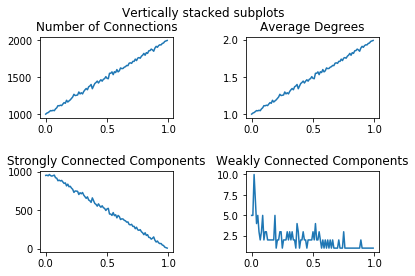

In [44]:
# Analysis and Visualisation

stages = []
i = 0
while(i <= 1):
    stages.append(i)
    i += step

fig, axs = plt.subplots(2,2)
fig.suptitle('Vertically stacked subplots')
axs[0, 0].set_title('Number of Connections')
axs[0 ,0].plot(stages, number_of_connections)
axs[0, 1].set_title('Average Degrees')
axs[0 ,1].plot(stages, average_degrees)
axs[1, 0].set_title('Strongly Connected Components')
axs[1 ,0].plot(stages, SCCS)
axs[1, 1].set_title('Weakly Connected Components')
axs[1, 1].plot(stages, WCCS)

fig.tight_layout(pad=2.0)

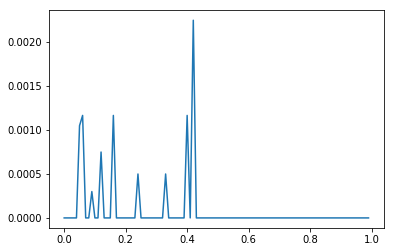

In [45]:
plt.plot(stages, ACCS)

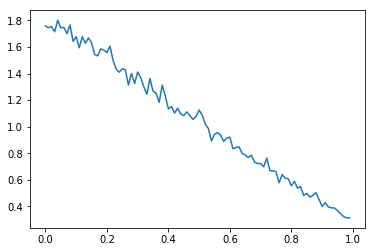

In [46]:
plt.plot(stages, Ascendencies)

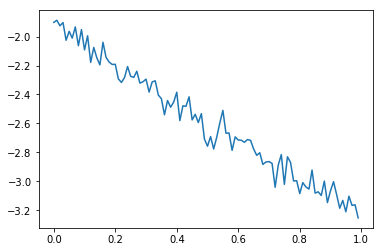

In [47]:
plt.plot(stages, development_capacities)

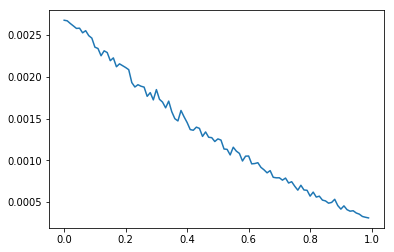

In [48]:
plt.plot(stages, average_mutual_informations)

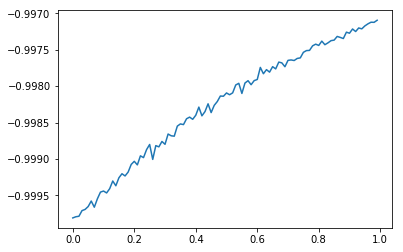

In [41]:
def Convert(lst):
    return [ -i for i in lst ]
plt.plot(stages, Convert(redundancies))

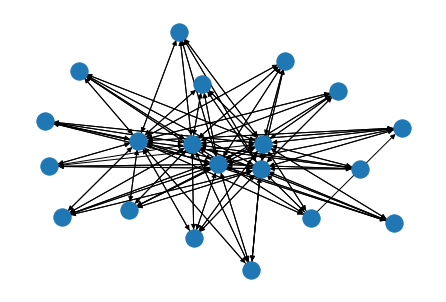

In [31]:
nx.draw(G) 
plt.show()

mixing_probability  0.0


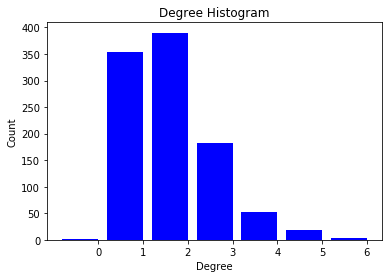

mixing_probability  0.01


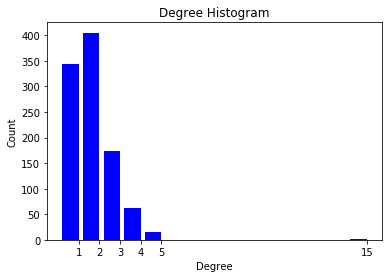

mixing_probability  0.02


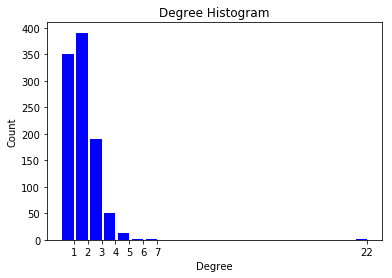

mixing_probability  0.03


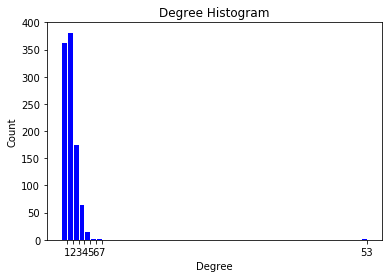

mixing_probability  0.04


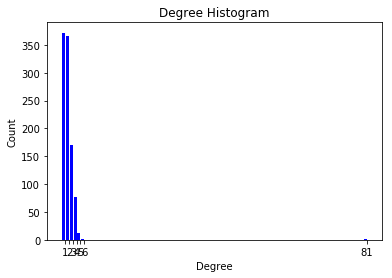

mixing_probability  0.05


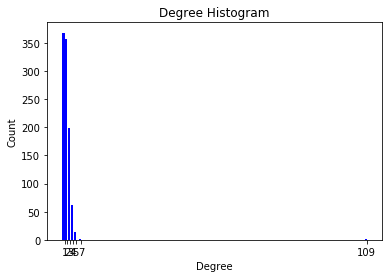

mixing_probability  0.060000000000000005


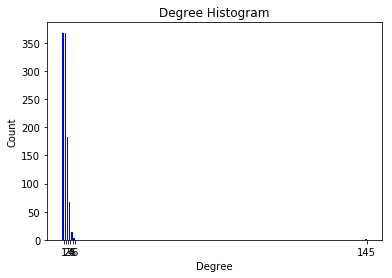

mixing_probability  0.07


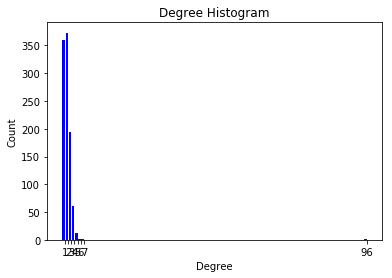

mixing_probability  0.08


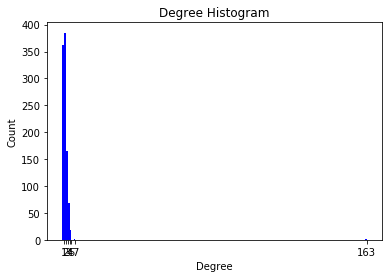

mixing_probability  0.09


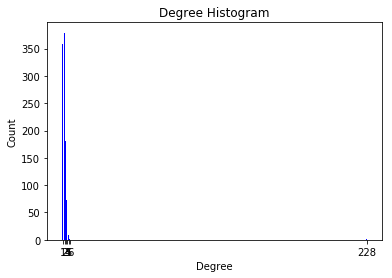

mixing_probability  0.09999999999999999


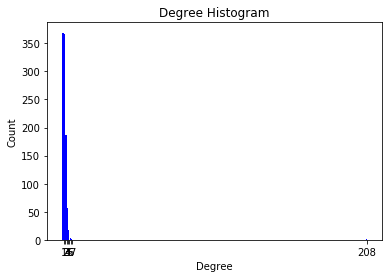

mixing_probability  0.10999999999999999


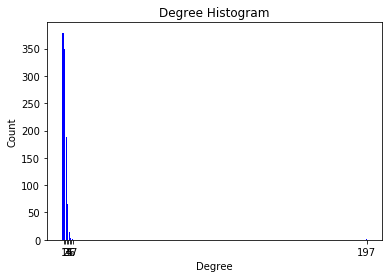

mixing_probability  0.11999999999999998


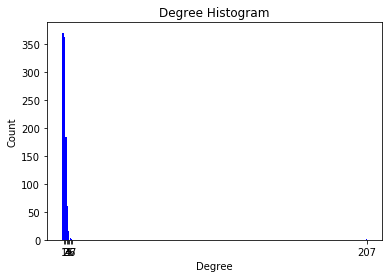

mixing_probability  0.12999999999999998


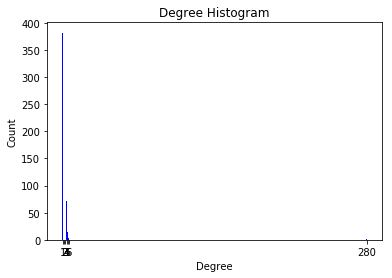

mixing_probability  0.13999999999999999


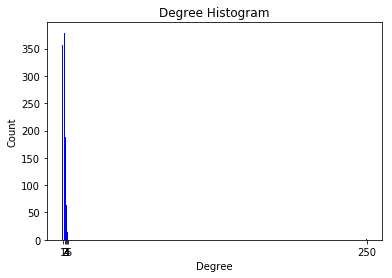

mixing_probability  0.15


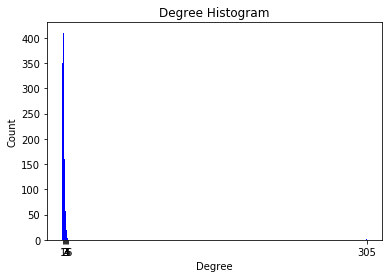

mixing_probability  0.16


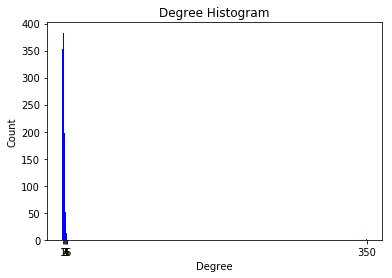

mixing_probability  0.17


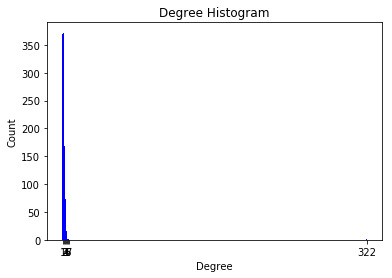

mixing_probability  0.18000000000000002


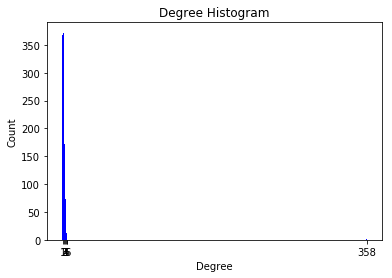

mixing_probability  0.19000000000000003


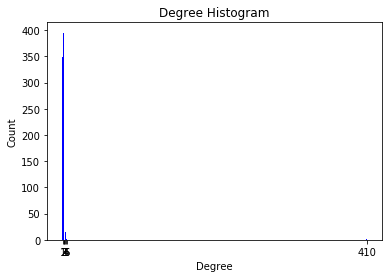

mixing_probability  0.20000000000000004


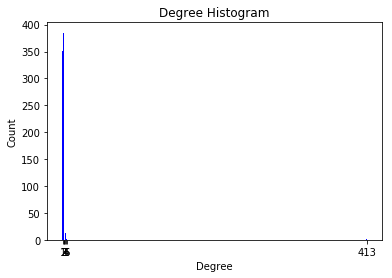

mixing_probability  0.21000000000000005


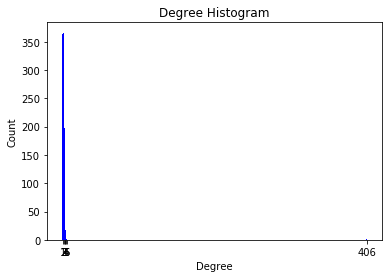

mixing_probability  0.22000000000000006


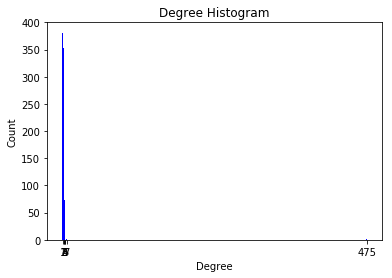

mixing_probability  0.23000000000000007


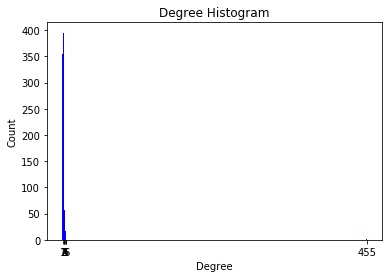

mixing_probability  0.24000000000000007


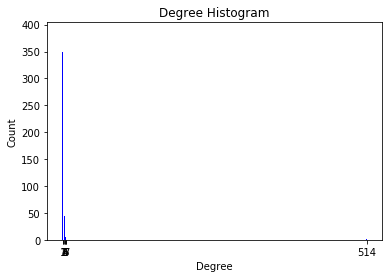

mixing_probability  0.25000000000000006


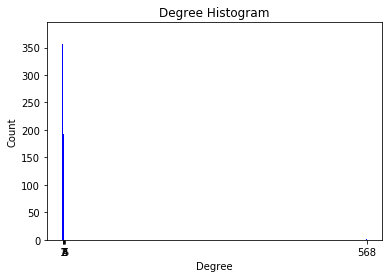

mixing_probability  0.26000000000000006


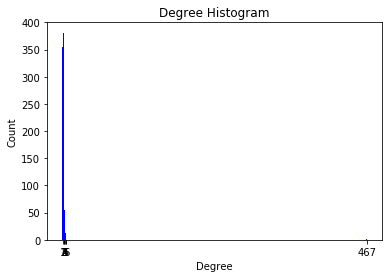

mixing_probability  0.2700000000000001


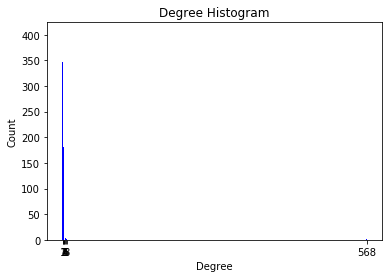

mixing_probability  0.2800000000000001


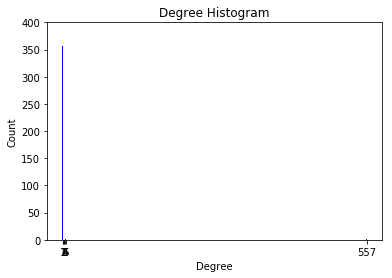

mixing_probability  0.2900000000000001


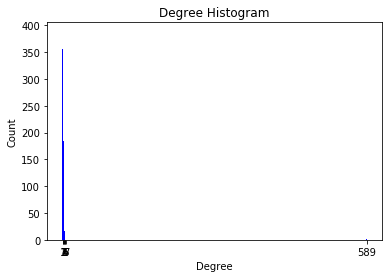

mixing_probability  0.3000000000000001


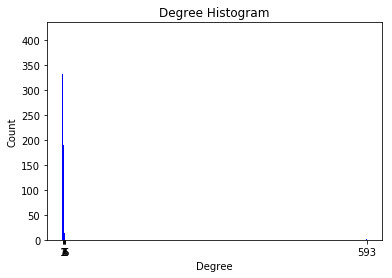

mixing_probability  0.3100000000000001


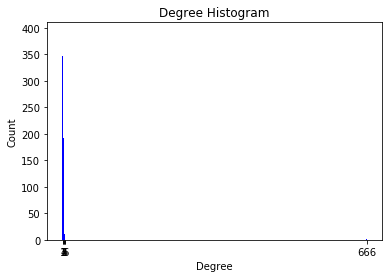

mixing_probability  0.3200000000000001


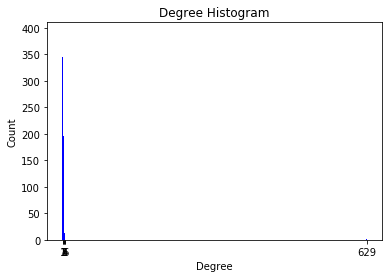

mixing_probability  0.3300000000000001


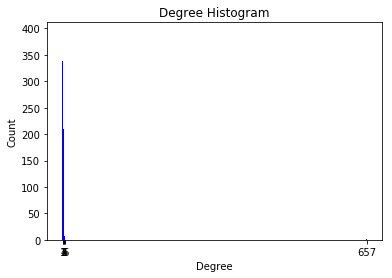

mixing_probability  0.34000000000000014


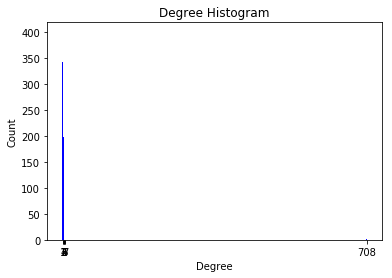

mixing_probability  0.35000000000000014


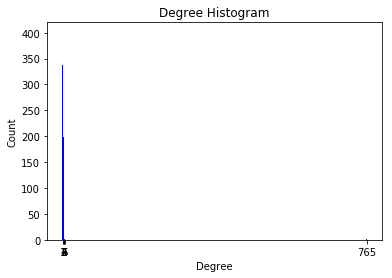

mixing_probability  0.36000000000000015


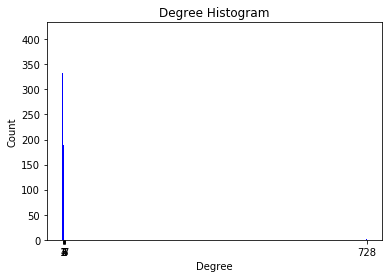

mixing_probability  0.37000000000000016


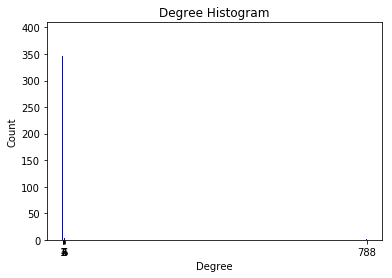

mixing_probability  0.38000000000000017


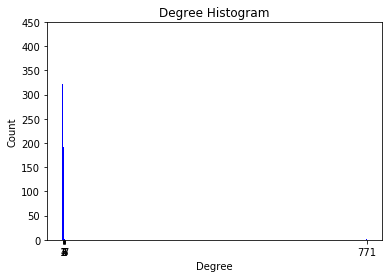

mixing_probability  0.3900000000000002


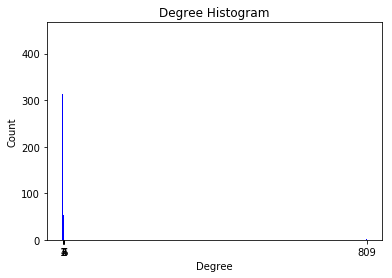

mixing_probability  0.4000000000000002


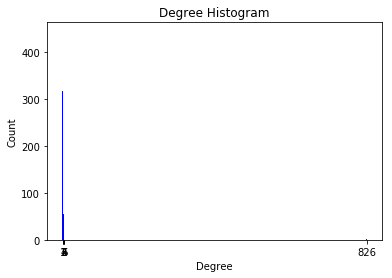

mixing_probability  0.4100000000000002


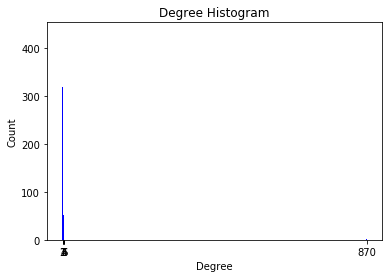

mixing_probability  0.4200000000000002


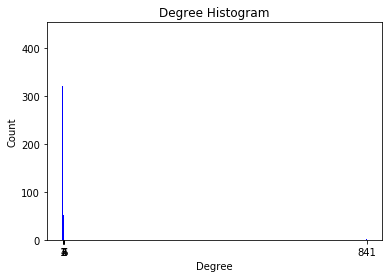

mixing_probability  0.4300000000000002


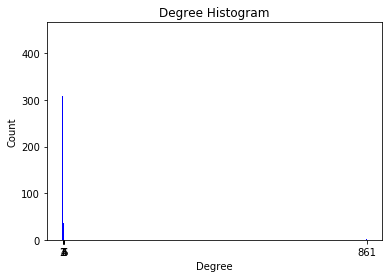

mixing_probability  0.4400000000000002


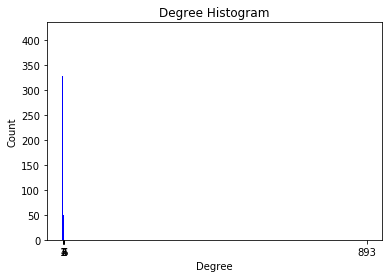

mixing_probability  0.45000000000000023


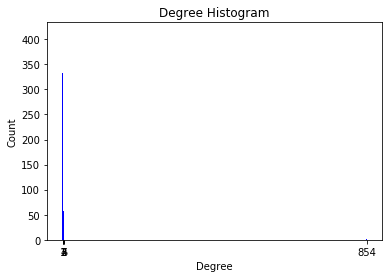

mixing_probability  0.46000000000000024


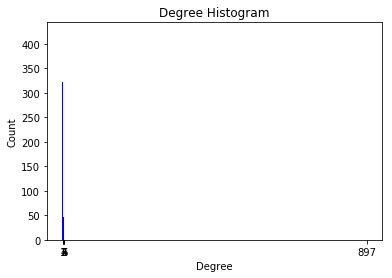

mixing_probability  0.47000000000000025


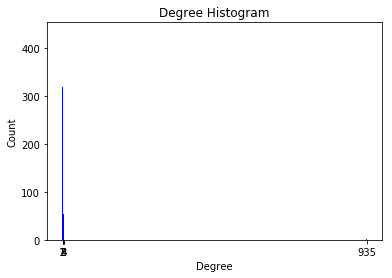

mixing_probability  0.48000000000000026


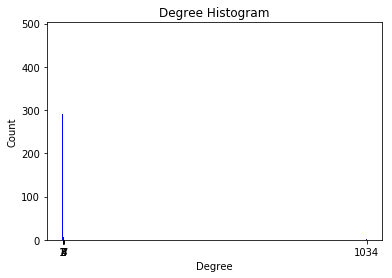

mixing_probability  0.49000000000000027


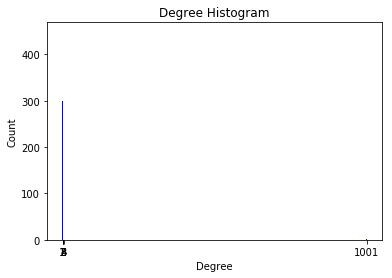

mixing_probability  0.5000000000000002


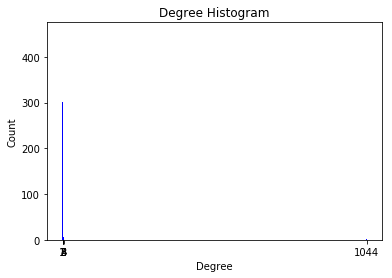

mixing_probability  0.5100000000000002


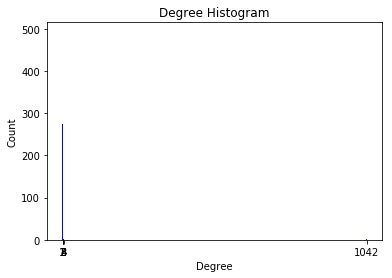

mixing_probability  0.5200000000000002


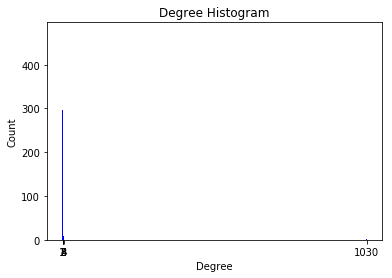

mixing_probability  0.5300000000000002


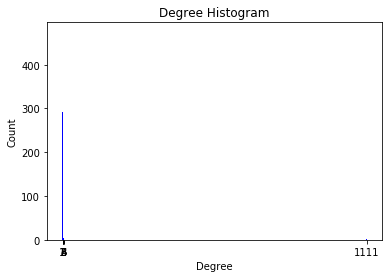

mixing_probability  0.5400000000000003


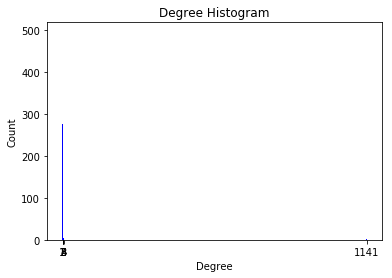

mixing_probability  0.5500000000000003


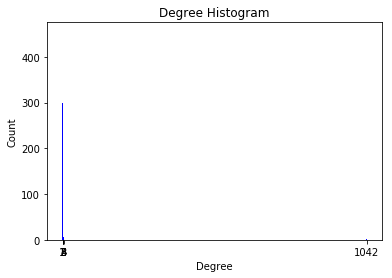

mixing_probability  0.5600000000000003


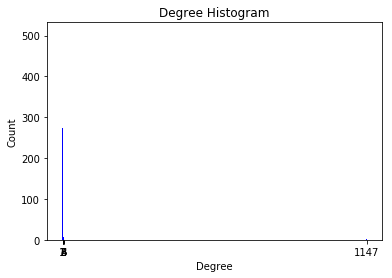

mixing_probability  0.5700000000000003


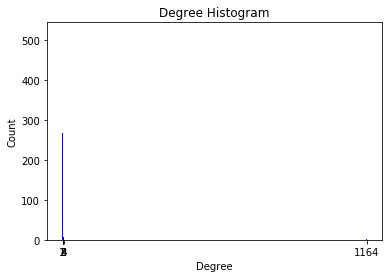

mixing_probability  0.5800000000000003


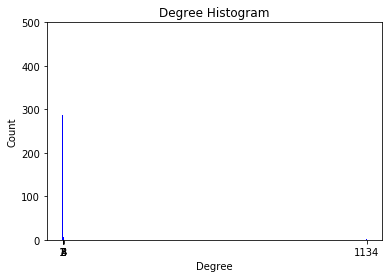

mixing_probability  0.5900000000000003


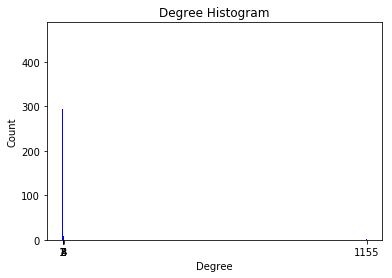

mixing_probability  0.6000000000000003


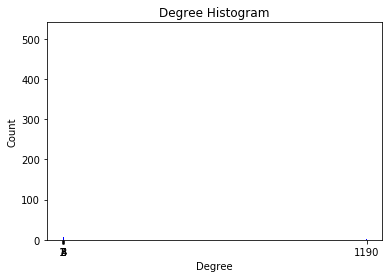

mixing_probability  0.6100000000000003


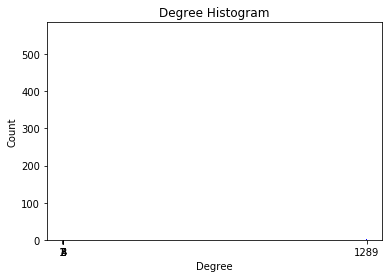

mixing_probability  0.6200000000000003


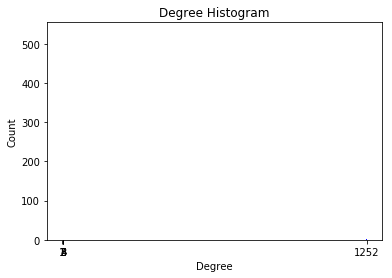

mixing_probability  0.6300000000000003


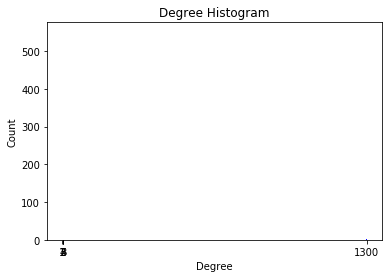

mixing_probability  0.6400000000000003


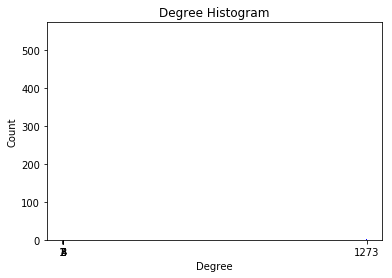

mixing_probability  0.6500000000000004


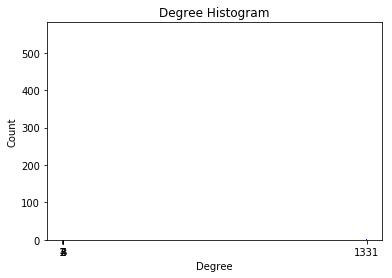

mixing_probability  0.6600000000000004


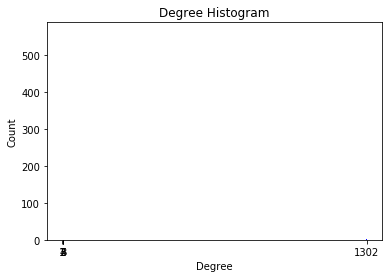

mixing_probability  0.6700000000000004


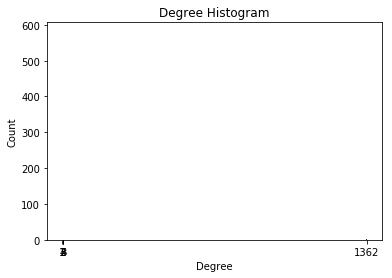

mixing_probability  0.6800000000000004


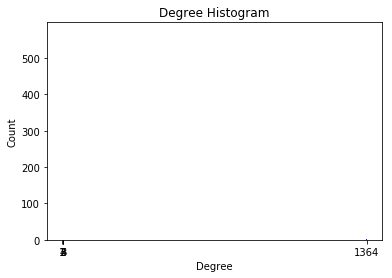

mixing_probability  0.6900000000000004


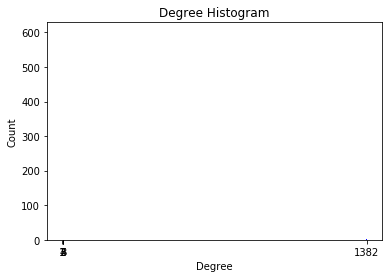

mixing_probability  0.7000000000000004


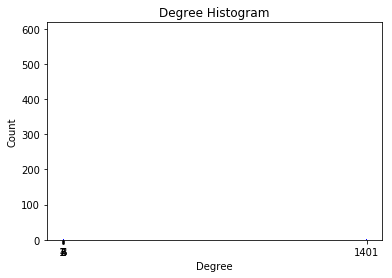

mixing_probability  0.7100000000000004


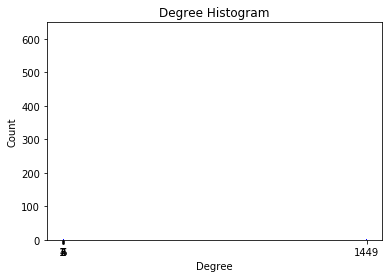

mixing_probability  0.7200000000000004


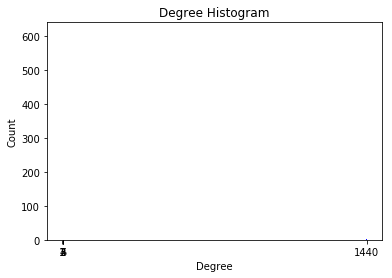

mixing_probability  0.7300000000000004


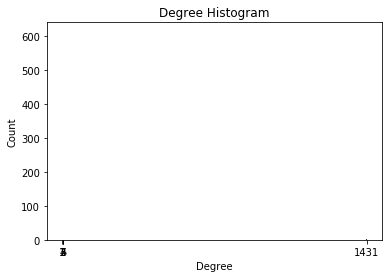

mixing_probability  0.7400000000000004


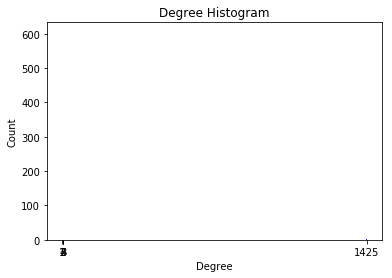

mixing_probability  0.7500000000000004


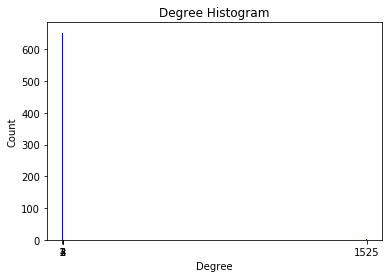

mixing_probability  0.7600000000000005


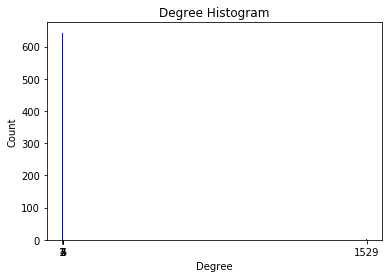

mixing_probability  0.7700000000000005


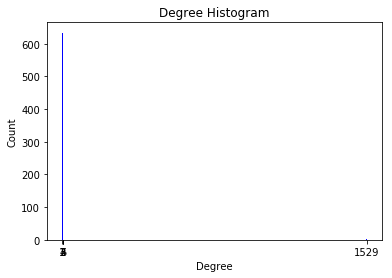

mixing_probability  0.7800000000000005


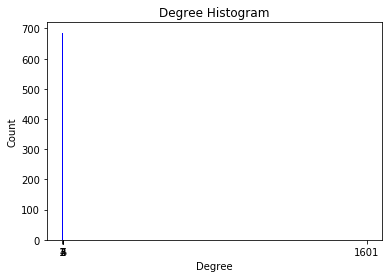

mixing_probability  0.7900000000000005


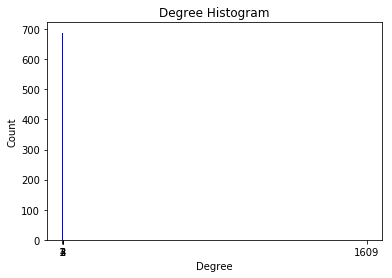

mixing_probability  0.8000000000000005


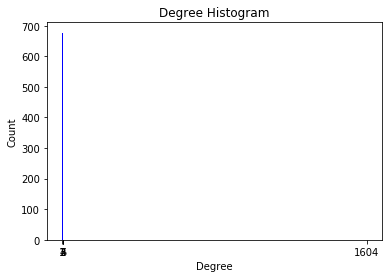

mixing_probability  0.8100000000000005


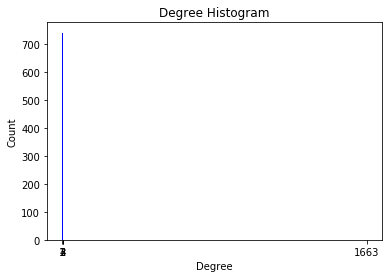

mixing_probability  0.8200000000000005


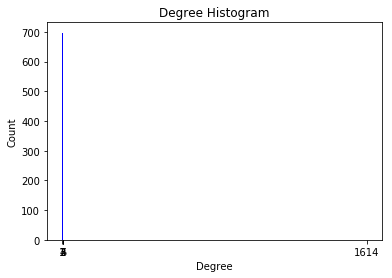

mixing_probability  0.8300000000000005


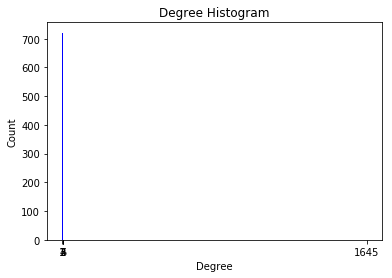

mixing_probability  0.8400000000000005


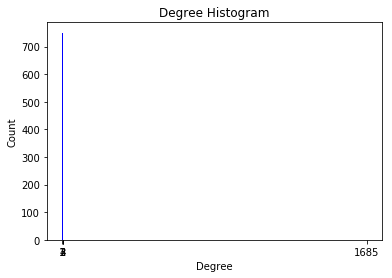

mixing_probability  0.8500000000000005


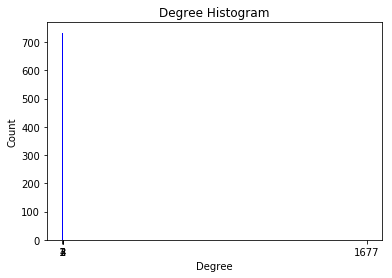

mixing_probability  0.8600000000000005


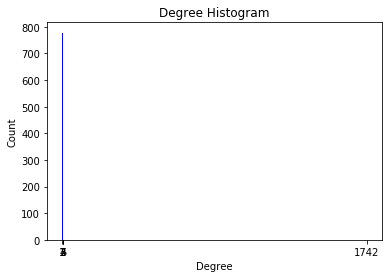

mixing_probability  0.8700000000000006


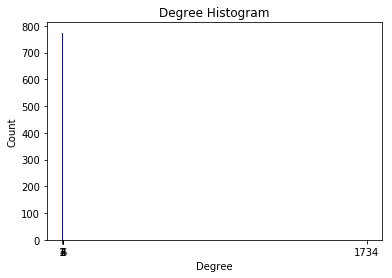

mixing_probability  0.8800000000000006


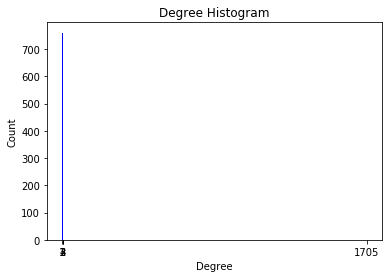

mixing_probability  0.8900000000000006


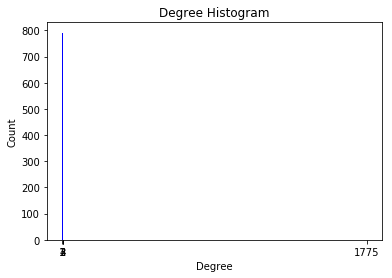

mixing_probability  0.9000000000000006


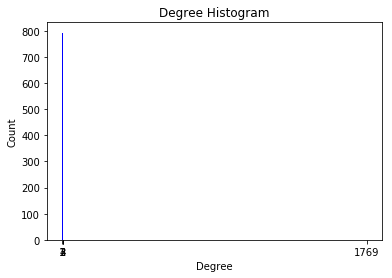

mixing_probability  0.9100000000000006


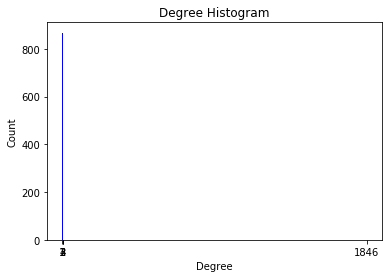

mixing_probability  0.9200000000000006


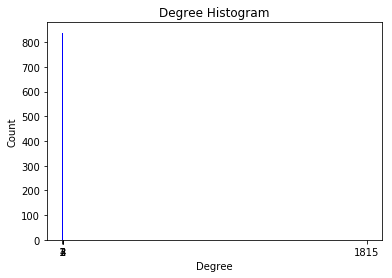

mixing_probability  0.9300000000000006


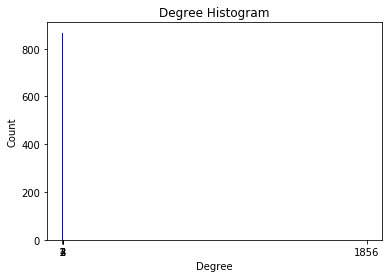

mixing_probability  0.9400000000000006


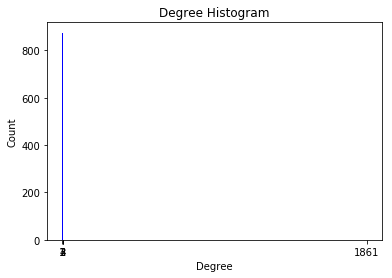

mixing_probability  0.9500000000000006


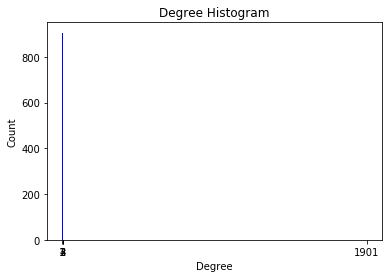

mixing_probability  0.9600000000000006


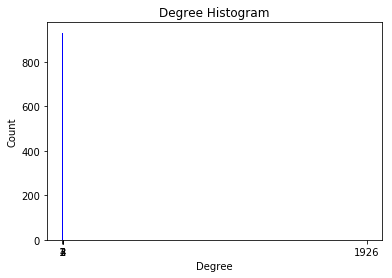

mixing_probability  0.9700000000000006


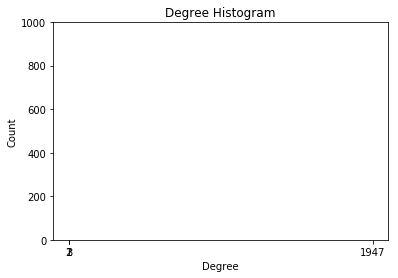

mixing_probability  0.9800000000000006


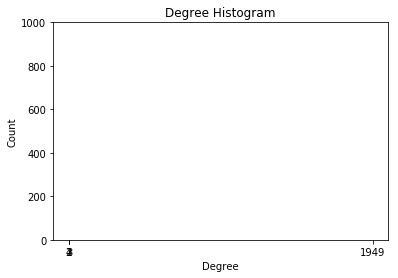

mixing_probability  0.9900000000000007


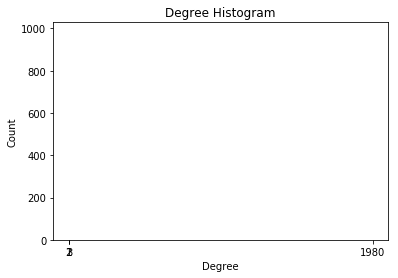

In [42]:
i = 0.0
for degreeCount in degreeCounts:
    print("mixing_probability ", i)
    i += step
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color="b")

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    plt.show()

In [145]:
path = "kronfit/test.txt"
G = nx.from_numpy_matrix(network, create_using=nx.DiGraph)
nx.write_edgelist(G, path, delimiter=' ', comments='#', encoding='utf-8', data = False)

In [ ]:
net = Network(notebook = True)
net.from_nx(G)
net.show("example.html")

In [142]:
# Kronecker Graph

k = world.blockchain.network
k2 = np.kron(k,k)

fig = plt.figure()

ax0 = fig.add_subplot(121)
# 'nearest' interpolation - faithful but blocky
ax0.imshow(k, interpolation='nearest', cmap=cm.Greys_r)

directed = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
directed.imshow(k2, interpolation='nearest', cmap=cm.Greys_r)

MemoryError: Unable to allocate array with shape (1002001, 1002001) and data type float64

In [9]:
tree_matrix =  np.array([[0, 1, 1, 0, 0, 0, 0],
                         [1, 0, 0, 1, 1, 0, 0],
                         [1, 0, 0, 0, 0, 1, 1], 
                         [0, 1, 0, 0, 0, 0, 0], 
                         [0, 1, 0, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0, 0]])

G = nx.from_numpy_matrix(tree_matrix, create_using=nx.DiGraph)
net = Network(notebook = True)
net.from_nx(G)
net.show("example.html")

In [122]:
class mixer(address):
    
    def __init__(self, mixer_id, *args, **kwargs):
        self.id = mixer_id
        self.addresses_in = []
        self.addresses_out = []
        self.sums = []
        super(mixer, self).__init__(*args, **kwargs)
    
    def add_to_mixng_pool(self, address_in, address_out, sum_to_send):
        self.addresses_in.append(address_in)
        self.addresses_out.append(address_out)
        self.sums.append(sum_to_send)
    
    def send_out(self):
        incoming = self.addresses_in
        outcoming = self.addresses_in
        sums_out = self.sums
        self.addresses_in = []
        self.addresses_out = []
        self.sums = []
        return outcoming, sums_out
        
    

class user(address):
    
    def __init__(self, mixing_probability, mixer_address, *args, **kwargs):
        self.mixing_probability = mixing_probability 
        self.mixer_address = mixer_address
        super(user, self).__init__(*args, **kwargs)
        
    def generate_transfer(self, blockchain_size):
        probabilities = [1 - self.mixing_probability, self.mixing_probability]
        action = random.choices([0,1], weights = probabilities, k = 1) 
        amount_to_send = self.coins * random.uniform(0, 1)
        
        address_to_send = -1
        while(address_to_send == -1 or address_to_send == self.mixer_address):
            address_to_send = np.random.choice(blockchain_size, 1)
        
        return action[0], address_to_send[0], amount_to_send
        
        